In [2]:
import os
import numpy as np
import time

# make sure the notebook is run from the root folder of maximal-empty-spheres
base_path = os.path.join(os.getcwd())

out_folder = os.path.join(base_path,"output")
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

# Data

Download Armadillo, Koalla and Bunny meshes

In [3]:
data_folder = os.path.join(base_path,"data")
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
    
from utils.data import download_meshes
mesh_paths = download_meshes(data_folder)

print(f"\nAvailable Meshes: {list(mesh_paths.keys())}")

camera_views = {"armadillo" : (v_ := np.array([0.,0.,-1.])*2.8,-v_),
                "koala"     : (v_ := np.array([0.4,0.,1.])*2.4,-v_)
}

crops = {
            "armadillo" : [50,120,700,700],
            "koala"     : [100,0,775,775],
            "bunny"     : [0,0,500,775],
}

Found .obj file for armadillo
Found .obj file for koala
Found .obj file for bunny

Available Meshes: ['armadillo', 'koala', 'bunny']


# GT Sampling

In [4]:
import numpy as np
def sample_positions(n, random_sampling, sdf):
    if random_sampling:
        U = (np.random.rand(n*n*n, 3)-0.5)*2
    else:
        gx, gy, gz = np.meshgrid(np.linspace(-1.0, 1.0, n+1), np.linspace(-1.0, 1.0, n+1), np.linspace(-1.0, 1.0, n+1))
        U = np.vstack((gx.flatten(), gy.flatten(), gz.flatten())).T
    U_sdfvals = sdf(U)
    return U, U_sdfvals

import gpytoolbox as gpy

def GT_sdf(mesh_path):
    # Set up gt
    V_gt, F_gt = gpy.read_mesh(mesh_path)
    V_gt = gpy.normalize_points(V_gt)

    s = 0.9 # 0.75
    V_gt *= s/0.5

    # Create and abstract SDF function that is the only connection to the shape
    sdf = lambda x: gpy.signed_distance(x, V_gt, F_gt)[0]
    
    return (V_gt, F_gt), sdf

# Contouring

In [5]:
from matplotlib.colors import to_rgb
method_colors = {"RFTA":"tab:blue", "MES": "tab:orange", "MC" : "tab:green"}

In [6]:
from cgal.EmptySpheresReconstruction import MESReconstruction

# use the same screening weight for RFTA and MES
screening_weight = 1.

method_calls = {
    "RFTA" : lambda U,D,N=None : gpy.reach_for_the_arcs(U,D,screening_weight=screening_weight,parallel=True),
    "MES"  : lambda U,D,N=None : MESReconstruction(U,D,screening_weight=screening_weight,cleanup=True),
    "MC"   : lambda U,D,N      : gpy.marching_cubes(D,U,*[N+1 for n in range(3)]),
}

In [7]:
from tqdm.notebook import tqdm

mesh    = "armadillo"
Ns      = [10,20,30,40,50,60,70]
methods = ["RFTA",
           "MES",
           "MC",
]

reconstructions = {m:{} for m in methods}
timings         = {m:{} for m in methods}

# ---------------
for N in tqdm(Ns):
    GT, sdf = GT_sdf(mesh_paths[mesh])
    U,D = sample_positions(N,False,sdf)
    
    for m in tqdm(methods,leave=False):
        if m in method_calls.keys():
            try:
                strt = time.time()
                reconstructions[m][N] = method_calls[m](U,D,N)
                stp  = time.time()
                timings[m][N] = stp-strt
                
            except Exception as e:
                print(f"... {m} failed\n{e}")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Read 1331 spheres
... main calculation... 
Gp: 1284
Loaded SDF values of shape (1284, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 1284 points computed in 0.144879 seconds.
n_check_planes: 16
NC.shape(): 1284, 6
N sols (unfiltered): 14810
Filtered 0 spheres that were not in the cone
Solutions.size: 5698, 6
Gn: 47
Loaded SDF values of shape (47, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 47 points computed in 0.000972 seconds.
n_check_planes: 16
NC.shape(): 47, 6
N sols (unfiltered): 446
Filtered 0 spheres that were not in the cone
Solutions.size: 187, 6
Computed 1271 contact points with normals in 0.25114 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 9261 spheres
... main calculation... 
Gp: 8863
Loaded SDF values of shape (8863, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 8863 points computed in 1.01262 seconds.
n_check_planes: 16
NC.shape(): 8863, 6
N sols (unfiltered): 103969
Filtered 0 spheres that were not in the cone
Solutions.size: 27872, 6
Gn: 398
Loaded SDF values of shape (398, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 398 points computed in 0.017023 seconds.
n_check_planes: 16
NC.shape(): 398, 6
N sols (unfiltered): 4502
Filtered 0 spheres that were not in the cone
Solutions.size: 1905, 6
Computed 7510 contact points with normals in 1.79532 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 29791 spheres
... main calculation... 
Gp: 28434
Loaded SDF values of shape (28434, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 28434 points computed in 3.11845 seconds.
n_check_planes: 16
NC.shape(): 28434, 6
N sols (unfiltered): 350904
Filtered 0 spheres that were not in the cone
Solutions.size: 68491, 6
Gn: 1357
Loaded SDF values of shape (1357, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 1357 points computed in 0.05559 seconds.
n_check_planes: 16
NC.shape(): 1357, 6
N sols (unfiltered): 15563
Filtered 0 spheres that were not in the cone
Solutions.size: 6135, 6
Computed 20347 contact points with normals in 5.67482 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 68921 spheres
... main calculation... 
Gp: 65742
Loaded SDF values of shape (65742, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 65742 points computed in 7.99905 seconds.
n_check_planes: 16
NC.shape(): 65742, 6
N sols (unfiltered): 861667
Filtered 0 spheres that were not in the cone
Solutions.size: 127770, 6
Gn: 3179
Loaded SDF values of shape (3179, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 3179 points computed in 0.143675 seconds.
n_check_planes: 16
NC.shape(): 3179, 6
N sols (unfiltered): 36344
Filtered 0 spheres that were not in the cone
Solutions.size: 13584, 6
Computed 40223 contact points with normals in 13.9315 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 132651 spheres
... main calculation... 
Gp: 126373
Loaded SDF values of shape (126373, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 126373 points computed in 16.167 seconds.
n_check_planes: 16
NC.shape(): 126373, 6
N sols (unfiltered): 1718774
Filtered 0 spheres that were not in the cone
Solutions.size: 207627, 6
Gn: 6278
Loaded SDF values of shape (6278, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 6278 points computed in 0.316769 seconds.
n_check_planes: 16
NC.shape(): 6278, 6
N sols (unfiltered): 71602
Filtered 0 spheres that were not in the cone
Solutions.size: 25696, 6
Computed 68760 contact points with normals in 27.6148 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 226981 spheres
... main calculation... 
Gp: 216185
Loaded SDF values of shape (216185, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 216185 points computed in 29.9885 seconds.
n_check_planes: 16
NC.shape(): 216185, 6
N sols (unfiltered): 3050989
Filtered 0 spheres that were not in the cone
Solutions.size: 310860, 6
Gn: 10796
Loaded SDF values of shape (10796, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 10796 points computed in 0.566401 seconds.
n_check_planes: 16
NC.shape(): 10796, 6
N sols (unfiltered): 124112
Filtered 0 spheres that were not in the cone
Solutions.size: 42227, 6
Computed 106974 contact points with normals in 49.6321 sec.


  0%|          | 0/3 [00:00<?, ?it/s]

Read 357911 spheres
... main calculation... 
Gp: 340737
Loaded SDF values of shape (340737, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 340737 points computed in 51.0965 seconds.
n_check_planes: 16
NC.shape(): 340737, 6
N sols (unfiltered): 4931597
Filtered 0 spheres that were not in the cone
Solutions.size: 438310, 6
Gn: 17174
Loaded SDF values of shape (17174, 4)
Convert to Lie representation
All normals in the same halfspace? : true
Last component greater than zero?  : true
Convex hull of 17174 points computed in 0.925435 seconds.
n_check_planes: 16
NC.shape(): 17174, 6
N sols (unfiltered): 196911
Filtered 0 spheres that were not in the cone
Solutions.size: 64510, 6
Computed 156253 contact points with normals in 82.7071 sec.


In [8]:
import polyscope as ps
ps.init()
ps.set_up_dir("y_up")
ps.set_ground_plane_mode("none")

screenshots = {m:{} for m in methods}

for m in methods:
    for N in Ns:
        ps.remove_all_structures()
        ps.register_surface_mesh(m,*reconstructions[m][N], color=to_rgb(method_colors[m]))
        if mesh in camera_views.keys():
            ps.look_at(*camera_views[mesh])
        screenshots[m][N] = ps.screenshot_to_buffer()   

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 565.57.01


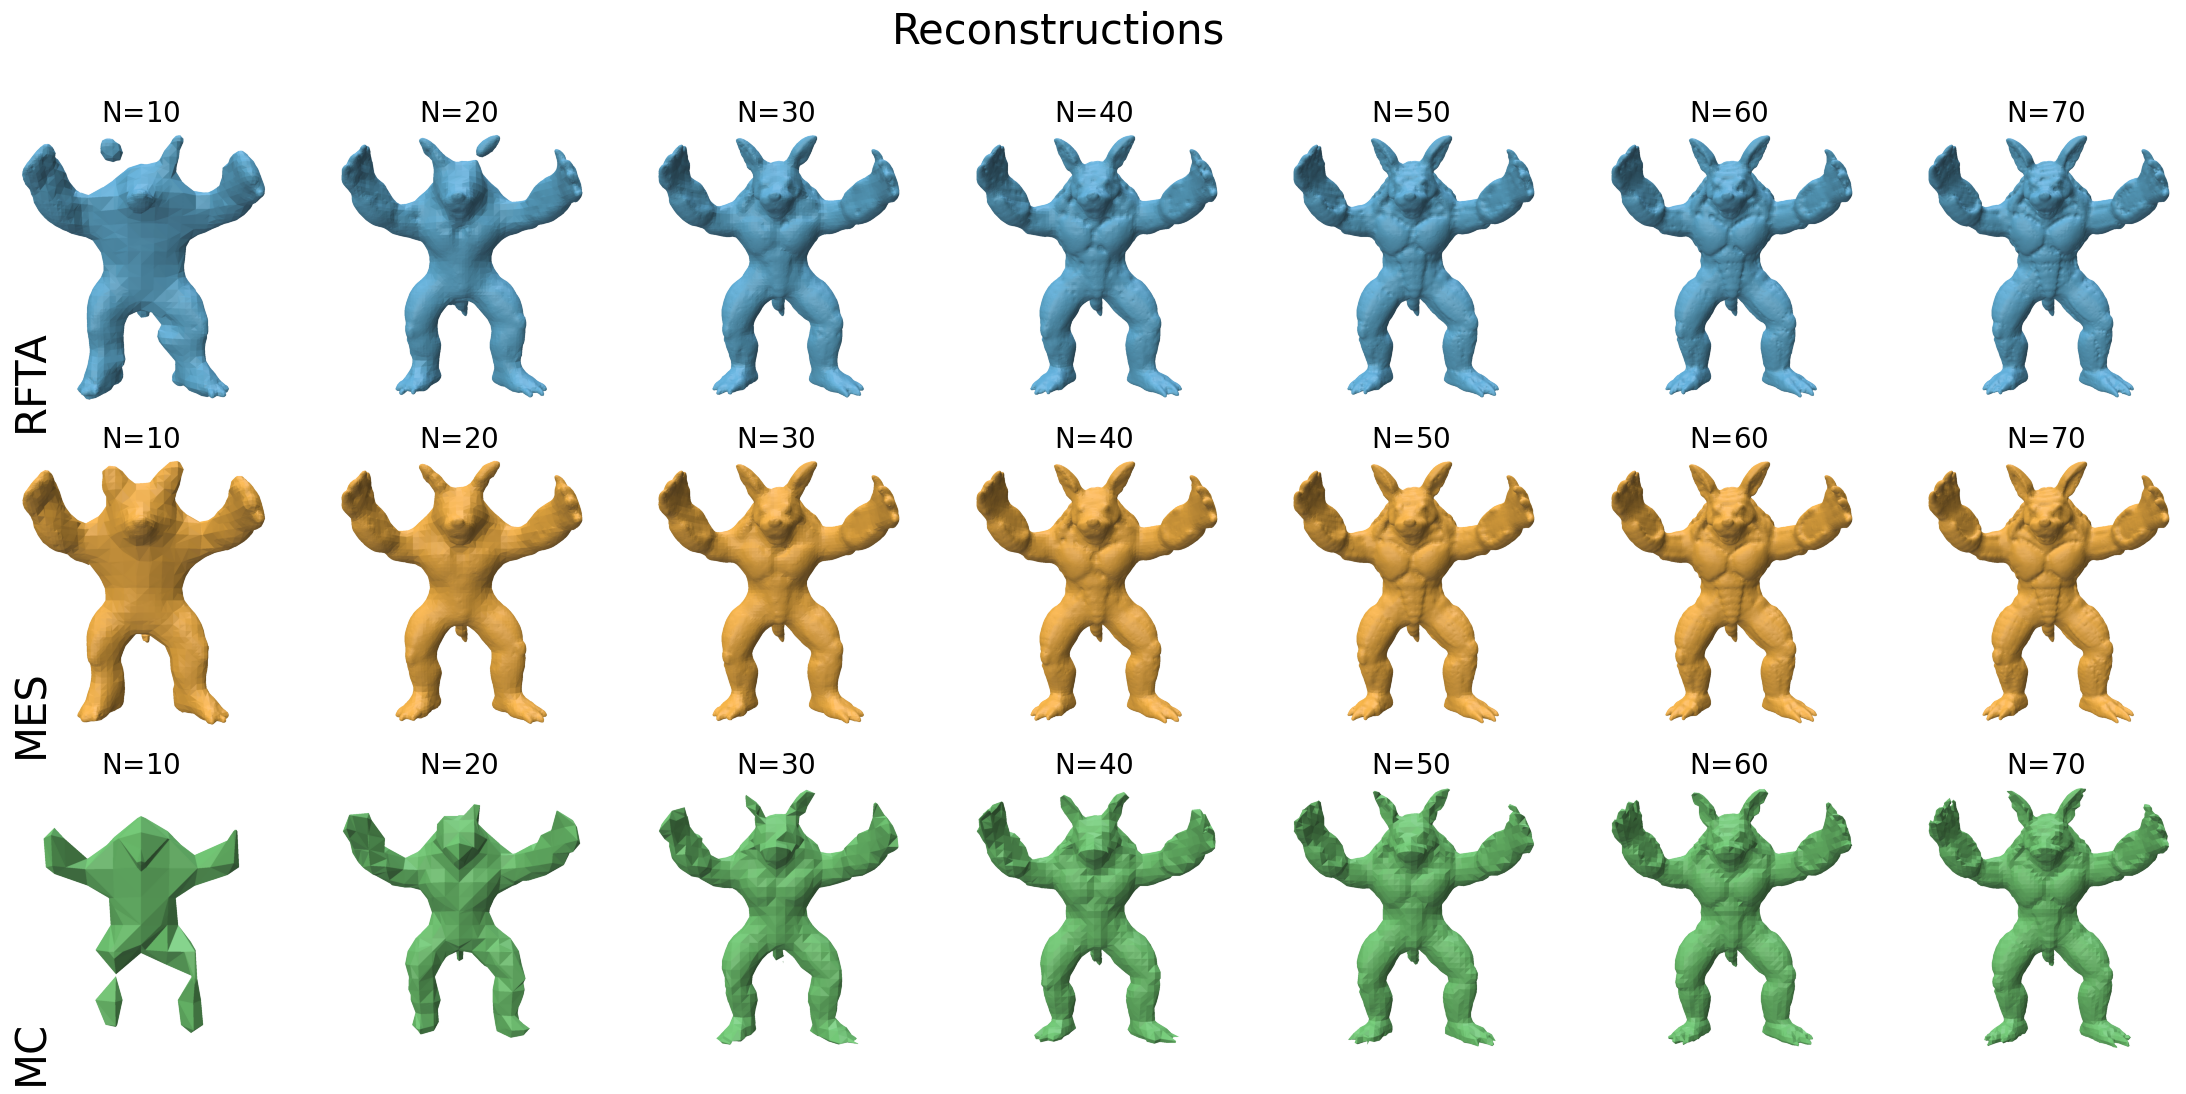

In [9]:
import matplotlib.pyplot as plt
nr,nc = len(methods), len(Ns)
fig, axs = plt.subplots(nr,nc,figsize=(4*nc,4*nr))
if nc==1:
    axs = [[a] for a in axs]
if nr==1:
    axs = [axs]
    
fig.suptitle("Reconstructions",fontsize=30)

for mi,m in enumerate(methods):
    for ni,(N,im) in enumerate(screenshots[m].items()):
        ax = axs[mi][ni]
        if ni==0:
            ax.text(0,1300,f"{m}",fontsize=30,rotation=90)
        ax.set_title(f"N=${N}$" ,fontsize=20)
        if mesh in crops.keys():
            u,d,l,r = crops[mesh]
            ax.imshow(screenshots[m][N][u:-(d+1),l:-r])
        else:
            ax.imshow(screenshots[m][N])
        ax.axis("off")
        
if True:
    plt.savefig(os.path.join(out_folder,f"{mesh}_reconstruction_comparison.pdf"),bbox_inches="tight")
plt.show()

# Mesh Distances

In [10]:
from utils.mesh_distances import ts_distances

mesh_metrics = []
for m in methods:
    for N in Ns:
        d1,d2,d3 = ts_distances(reconstructions[m][N],GT,1)
        mesh_metrics.append([m,N,timings[m][N],d1,d2,d3])
import pandas as pd
mesh_metrics = pd.DataFrame(mesh_metrics,columns=["Method","N","Time","Hausdorff","L1", "Chamfer"])

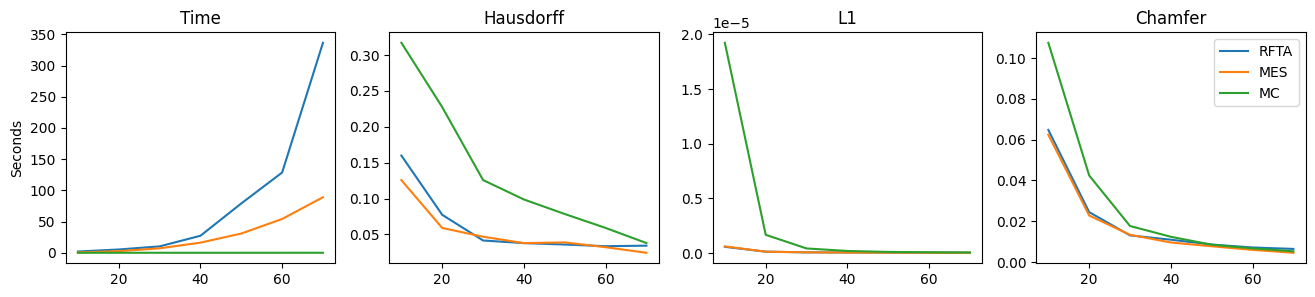

In [11]:
metrics = ["Time", "Hausdorff","L1", "Chamfer"]

fig,axs = plt.subplots(1,len(metrics),figsize=(4*len(metrics),3))

for _,m in enumerate(methods):
    for i,met in enumerate(metrics):
        df_ = mesh_metrics[mesh_metrics["Method"]==m][["N",met]]
        axs[i].plot(df_["N"],df_[met],label=m)
        axs[i].set_title(met)
        if met == "Time":
            axs[i].set_ylabel("Seconds")
        
plt.legend()

if True:
    plt.savefig(os.path.join(out_folder,f"{mesh}_rc_metrics.pdf"),bbox_inches="tight")
plt.show()